# Kaggle Competition Final Project (unfinished)

# *1C Company* - Predict Future Sales

**Motivation**

*This challenge serves as final project for the "How to win a data science competition" Coursera course. In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. We are asking you to **predict total sales for every product and store in the next month**. By solving this competition you will be able to apply and enhance your data science skills.*

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Submissions are evaluated by **root mean squared error** (RMSE). True target values are clipped into [0,20] range. For each id in the test set, you must predict a total number of sales.

Source: https://www.kaggle.com/c/competitive-data-science-final-project

**Summary**

    1. Getting a look at the data
    2. Preprocessing raw data into features
        2.1. Making sense of the test set ID values
        2.2. Extracting categorical features from Russian item names
        2.3. Remove duplicates
        2.4. Creating a starting point for data engineering
        2.5. Create lagged based features
        2.6. Create trend based features
        2.7. Feature matrix
    3. Exploratory data analysis
        3.1. Time series plot
        3.2. Categorical heatmaps
    4. Advanced feature engineering
        4.1. (K-Fold) Mean encoding on categorical features
        4.2. tSNE
    5. Model training
        5.1. Validation scheme
        5.2. Light GBM
        5.3. XGBoost
        5.4. CatBoost
        5.5. LSTM
    6. Ensembling and test predictions
        6.1. Bayesian hyperparameter optimization (only XGBoost)
        6.2. Ensembling
        6.3. Leaderboard test prediction
        6.4. Bonus: Interpretable A.I

**Guidelines**

1. *Clarity*: The clear step-by-step instruction on how to produce the final submit file is provided. Code has comments where it is needed and meaningful function names
2. *Feature preprocessing and generation with respect to models*: Several simple features are generated. For non-tree-based models preprocessing is used or the absence of it is explained
3. *Feature extraction from text and images*: Features from text are extracted. Special preprocessings for text are utilized (TF-IDF, stemming, levenshtening...)
4. *EDA*: Several interesting observations about data are discovered and explained. Target distribution is visualized, time trend is assessed
5. *Validation*: Type of train/test split is identified and used for validation. Type of public/private split is identified
6. *Data leakages*: Data is investigated for data leakages and investigation process is described. Found data leakages are utilized
7. *Metrics optimization*: Correct metric is optimized
8. *Advanced Features I (mean encodings)*: Mean-encoding is applied. Mean-encoding is set up correctly, i.e. KFold or expanding scheme are utilized correctly
9. *Advanced Features II*: At least one feature from this topic is introduced
10. *Hyperparameter tuning*: Parameters of models are roughly optimal
11. *Ensembles*: Ensembling is utilized (linear combination counts). Validation with ensembling scheme is set up correctly, i.e. KFold or Holdout is utilized. Models from different classes are utilized (at least two from the following: KNN, linear models, RF, GBDT, NN)

**Packages**

In [57]:
# Basic packages
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

# Utilities
import gc
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from math import ceil
import copy

# Machine learning packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
#from MulticoreTSNE import MulticoreTSNE as TSNE
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from sklearn.linear_model import LinearRegression, Ridge, Lasso, Lars
from bayes_opt import BayesianOptimization
import shap

# Part 1/6: Getting a look at the data

Let's take a quick look at what type of data we are dealing with, by using pandas' functions `shape`, `unique()` and `head()`.

In [5]:
path = 'data/'

# Training set. Daily historical data from January 2013 to October 2015.
train = pd.read_csv(path+'sales_train.csv.gz')

# Testing set. You need to forecast the sales for these shops and products for November 2015.
test = pd.read_csv(path+'test.csv.gz').set_index('ID')

# Additional information
items = pd.read_csv(path+'items.csv')
item_categories = pd.read_csv(path+'item_categories.csv')
shops = pd.read_csv(path+'shops.csv')

In [6]:
train['sales'] = train['item_cnt_day']*train['item_price']
print(train.shape)
print(train.nunique())
train.head()

(2935849, 7)
date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
sales             24775
dtype: int64


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales
0,02.01.2013,0,59,22154,999.00,1.00,999.00
1,03.01.2013,0,25,2552,899.00,1.00,899.00
2,05.01.2013,0,25,2552,899.00,-1.00,-899.00
3,06.01.2013,0,25,2554,"1,709.05",1.00,"1,709.05"
4,15.01.2013,0,25,2555,"1,099.00",1.00,"1,099.00"


In [7]:
print(test.shape)
print(test.nunique())
test.head()

(214200, 2)
shop_id      42
item_id    5100
dtype: int64


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [8]:
print(items.shape)
print(items.nunique())
items.head()

(22170, 3)
item_name           22170
item_id             22170
item_category_id       84
dtype: int64


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
print(item_categories.shape)
print(item_categories.nunique())
item_categories.head()

(84, 2)
item_category_name    84
item_category_id      84
dtype: int64


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


# Part 2/6: Preprocessing raw data into features

## 2.1. Making sense of the testing ID values

As the data is raw, we need preprocess it in order to extract features for monthly sales prediction. We notice in the testing set that each ID represents an item sold (`item_id`) at a particular shop (`shop_id`). Let's check if each ID represents a unique **item_id - shop_id** pair.

In [10]:
test1 = copy.copy(test)
test1['shop_id'] = test1['shop_id'].map(str)
test1['item_id'] = test1['item_id'].map(str)
test1['key'] = test1[['shop_id', 'item_id']].apply(lambda x: '-'.join(x), axis=1)
print(test1['key'].nunique() == len(test1))
del test1; gc.collect();

True


That is indeed the case.

## 2.2. Extracting categorical features from Russian item names

In [11]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [12]:
item_categories.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [13]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [14]:
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


## 2.3. Check for duplicates

In [15]:
cols = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(train.duplicated(subset=cols).value_counts())
train.drop_duplicates(subset=cols, inplace=True)

False    2935825
True          24
dtype: int64


## 2.4. Creating a starting point for data engineering (with test set)

In [16]:
train1 = []
cols = ['date_block_num','shop_id','item_id']
for block_num in range(34):
    temp = train[train.date_block_num==block_num]
    train1.append(np.array(list(product([block_num], temp['shop_id'].unique(), temp['item_id'].unique()))))
    
train1 = pd.DataFrame(np.vstack(train1), columns=cols)
train1['date_block_num'] = train1['date_block_num'].astype(np.int8)
train1['shop_id'] = train1['shop_id'].astype(np.int8)
train1['item_id'] = train1['item_id'].astype(np.int16)
train1.sort_values(cols,inplace=True);
train1.head()

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


In [17]:
temp = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
temp.columns = ['item_cnt_month']
temp.reset_index(inplace=True)

train1 = pd.merge(train1, temp, on=cols, how='left')
train1['item_cnt_month'] = (train1['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))
print(train1.shape)
train1.head()

(10913850, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.00
1,0,0,27,0.00
2,0,0,28,0.00
3,0,0,29,0.00
4,0,0,32,6.00


One of the most challenging aspects of this competition is that the testing set to be submitted on Kaggle is devoid of features. The test set represents pairs of `(item ID, shop ID)` for the month of November 2015. It is thus a time series problem where we are using sales' results from January 2013 to October 2015 to predict future sales (November 2015). We add the test set to the train set by adding a 34th `date_block_num` key.

In [18]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

train2 = pd.concat([train1, test], ignore_index=True, sort=False, keys=cols)
train2.fillna(0, inplace=True)
print(train2.shape)
train2.tail()

(11128050, 4)


,date_block_num,shop_id,item_id,item_cnt_month
11128045,34,45,18454,0.00
11128046,34,45,16188,0.00
11128047,34,45,15757,0.00
11128048,34,45,19648,0.00
11128049,34,45,969,0.00


## 2.5. Create lagged features

- *date_avg_item_cnt*
- *date_item_avg_item_cnt*
- *date_shop_avg_item_cnt*
- *date_cat_avg_item_cnt*
- *date_shop_cat_avg_item_cnt*
- *date_shop_subtype_avg_item_cnt*
- *date_city_avg_item_cnt*
- *date_shop_type_avg_item_cnt*
- *date_shop_subtype_avg_item_cnt*
- *date_item_city_avg_item_cnt*
- *date_type_avg_item_cnt*
- *date_subtype_avg_item_cnt*

In [19]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [20]:
train3 = pd.merge(train2, shops, on=['shop_id'], how='left')
train3 = pd.merge(train3, items, on=['item_id'], how='left')
train3 = pd.merge(train3, item_categories, on=['item_category_id'], how='left')

In [21]:
########## 1. Create 'date_avg_item_cnt'
temp = train3.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_avg_item_cnt']          ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num'], how='left')
train3 = lag_feature(train3, [1], 'date_avg_item_cnt')
train3.drop(['date_avg_item_cnt'], axis=1, inplace=True)

########## 2. Create 'date_item_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_item_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','item_id'], how='left')
train3 = lag_feature(train3, [1,2,3,6,12], 'date_item_avg_item_cnt')
train3.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

########## 3. Create 'date_shop_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','shop_id'], how='left')
train3 = lag_feature(train3, [1,2,3,6,12], 'date_shop_avg_item_cnt')
train3.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

########## 4. Create 'date_cat_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_cat_avg_item_cnt']      ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num','item_category_id'], how='left')
train3 = lag_feature(train3, [1], 'date_cat_avg_item_cnt')
train3.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

########## 5. Create 'date_shop_cat_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_cat_avg_item_cnt']    ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_cat_avg_item_cnt')
train3.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

########## 6. Create 'date_shop_type_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_type_avg_item_cnt']    ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'type_code'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_type_avg_item_cnt')
train3.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

########## 7. Create 'date_type_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_type_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'type_code'], how='left')
train3 = lag_feature(train3, [1], 'date_type_avg_item_cnt')
train3.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

########## 8. Create 'date_city_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_city_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'city_code'], how='left')
train3 = lag_feature(train3, [1], 'date_city_avg_item_cnt')
train3.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

########## 9. Create 'date_shop_subtype_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_shop_subtype_avg_item_cnt']   ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
train3 = lag_feature(train3, [1], 'date_shop_subtype_avg_item_cnt')
train3.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

########## 10. Create 'date_item_city_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_item_city_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'item_id', 'city_code'], how='left')
train3 = lag_feature(train3, [1], 'date_item_city_avg_item_cnt')
train3.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

########## 11. Create 'date_subtype_avg_item_cnt'
temp = train3.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
temp.columns = ['date_subtype_avg_item_cnt']     ###
temp.reset_index(inplace=True)
train3 = pd.merge(train3, temp, on=['date_block_num', 'subtype_code'], how='left')
train3 = lag_feature(train3, [1], 'date_subtype_avg_item_cnt')
train3.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
train3.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,0,19,0.00,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0,0,27,0.00,29,19,5,10,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0,0,28,0.00,29,30,8,55,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0,0,29,0.00,29,23,5,16,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0,0,32,6.00,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## 2.6. Create time series trend features

We also want to capture past trends that might give us a hint of the future sales evolution (and thus information on the testing set).

In [22]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [23]:
# Trend features for prices
temp = train.groupby(['item_id']).agg({'item_price': ['mean']})
temp.columns = ['item_avg_item_price']
temp.reset_index(inplace=True)
train4 = pd.merge(train3, temp, on=['item_id'], how='left')

temp = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
temp.columns = ['date_item_avg_item_price']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['date_block_num','item_id'], how='left')

lags = [1,2,3,4,5,6]
train4 = lag_feature(train4, lags, 'date_item_avg_item_price')

for i in lags:
    train4['delta_price_lag_'+str(i)] = \
    (train4['date_item_avg_item_price_lag_'+str(i)] - train4['item_avg_item_price']) / train4['item_avg_item_price']
    
train4['delta_price_lag'] = train4.apply(select_trend, axis=1)
train4['delta_price_lag'].fillna(0, inplace=True)

dropped_cols = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    dropped_cols += ['date_item_avg_item_price_lag_'+str(i)]
    dropped_cols += ['delta_price_lag_'+str(i)]

train4.drop(dropped_cols, axis=1, inplace=True)

In [24]:
# Trend features for revenue
temp = train.groupby(['date_block_num','shop_id']).agg({'sales': ['sum']})
temp.columns = ['date_shop_revenue']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['date_block_num','shop_id'], how='left')

temp = train4.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
temp.columns = ['shop_avg_revenue']
temp.reset_index(inplace=True)
train4 = pd.merge(train4, temp, on=['shop_id'], how='left')

train4['delta_revenue'] = (train4['date_shop_revenue'] - train4['shop_avg_revenue']) / train4['shop_avg_revenue']
train4 = lag_feature(train4, [1], 'delta_revenue')
train4.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [25]:
train4['delta_revenue_lag_1'] = train4['delta_revenue_lag_1'].fillna(0.0)

In [26]:
print(train4.shape)
train4.head()

(11128050, 29)


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,...,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,0,19,0.00,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00
1,0,0,27,0.00,29,19,5,10,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00
2,0,0,28,0.00,29,30,8,55,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00
3,0,0,29,0.00,29,23,5,16,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00
4,0,0,32,6.00,29,40,11,4,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00


## 2.7. Feature matrix

In [30]:
df = train4[train4['date_block_num'] > 11]
print(df.shape)

for col in df.columns:
    if ('_lag_' in col) & (df[col].isnull().any()):
        if ('item_cnt' in col):
            df[col].fillna(0, inplace=True)   

(6639294, 29)


In [31]:
df.columns.values

array(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'city_code', 'item_category_id', 'type_code', 'subtype_code',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1'], dtype=object)

In [32]:
cat_features = ['shop_id', 'item_id', 'city_code', 'item_category_id', 'type_code', 'subtype_code']

num_features = ['date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
                'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
                'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
                'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
                'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
                'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
                'date_shop_cat_avg_item_cnt_lag_1',
                'date_shop_type_avg_item_cnt_lag_1',
                'date_shop_subtype_avg_item_cnt_lag_1_x',
                'date_city_avg_item_cnt_lag_1',
                'date_shop_subtype_avg_item_cnt_lag_1_y',
                'date_item_city_avg_item_cnt_lag_1',
                'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
                'delta_revenue_lag_1']

target = ['item_cnt_month']

# Part 3/6: Exploratory data analysis

## 3.1. Time series plots

The **target variable** to be predicted is the `item_cnt_day` (number of products sold). Let's check its time series evolution:

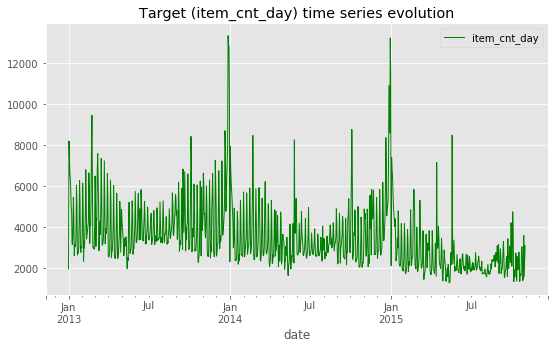

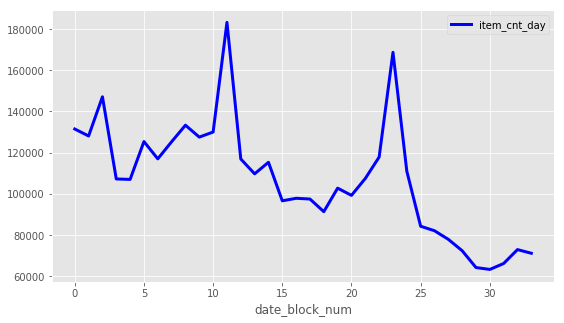

In [27]:
train['date'] = pd.to_datetime(train['date'], format="%d.%m.%Y")
train.groupby('date').agg({'item_cnt_day': 'sum'}).plot(figsize=(9,5), title='Target (item_cnt_day) time series evolution', lw=1.0, color='green')
train.groupby('date_block_num').agg({'item_cnt_day': 'sum'}).plot(figsize=(9,5), lw=3.0, color='blue')
plt.show()

Next we look at the daily performance of each shop:

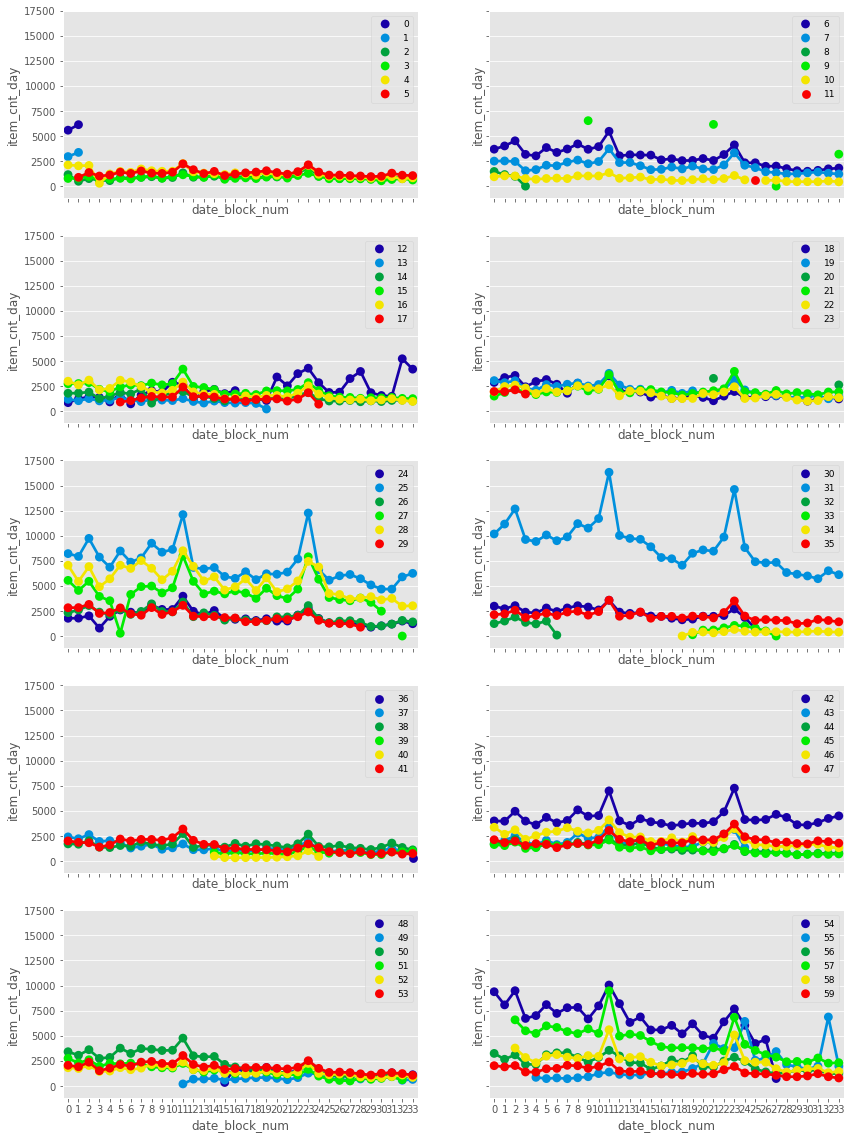

In [28]:
temp = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(14,20))
num_graph = 10
id_per_graph = ceil(temp.shop_id.max() / num_graph)
#fig.suptitle('Time series evolution of sales (per shop)')
x = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', palette='nipy_spectral',
                      data=temp[np.logical_and(x*id_per_graph <= temp['shop_id'],
                                               temp['shop_id'] < (x+1)*id_per_graph)],
                      ax=axes[i][j], grid=True, lw=1.0)
        #plt.legend(loc='best')
        axes[i,j].legend(loc='upper right')
        plt.setp(axes[i,j].get_legend().get_texts(), fontsize='9')
        plt.setp(axes[i,j].get_legend().get_title(), fontsize='10')
        x += 1

sns.reset_orig()

## 3.2. Multivariate heatmaps (numerical/categorical pairings)

An interesting visualization approach would be to pair different categorical variables (ex. `item_category_id`, `shop_id`, `city_code`) together and check the *performance* of different pairs (total sales' performance) (`item_cnt_month`).

Several item categories are barely (or not even) sold among a number of shops.

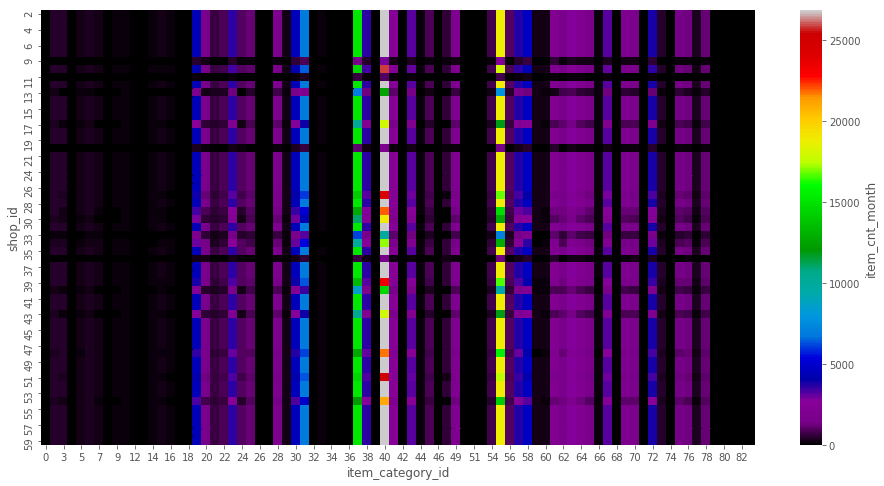

In [29]:
stores_hm = df.pivot_table(index='shop_id', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(stores_hm, cmap='nipy_spectral', ax=ax, cbar=True, cbar_kws={'label': 'item_cnt_month'});

The same goes for cities:

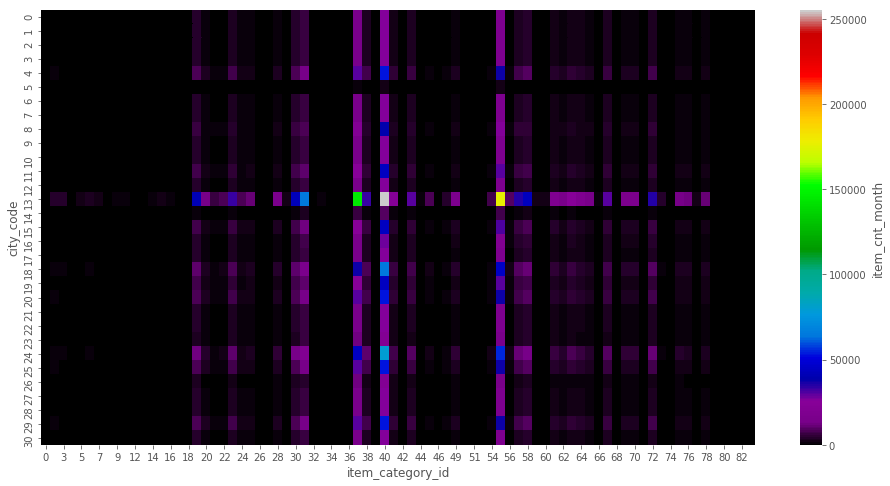

In [50]:
stores_hm = df.pivot_table(index='city_code', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(stores_hm, cmap='nipy_spectral', ax=ax, cbar=True, cbar_kws={'label': 'item_cnt_month'});

This additional plot reveals the number of shops per cities and their sales' performance.

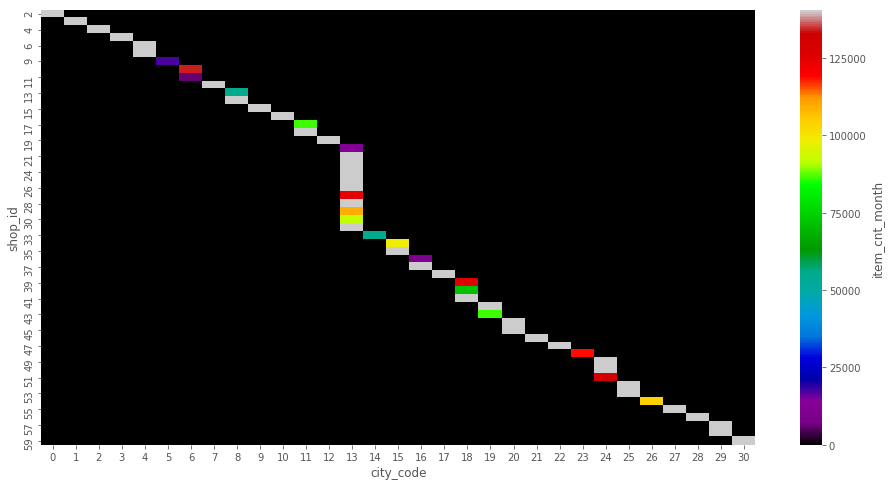

In [31]:
stores_hm = df.pivot_table(index='shop_id', columns='city_code', values='item_cnt_month', aggfunc='count', fill_value=0)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(stores_hm, cmap='nipy_spectral', ax=ax, cbar=True, cbar_kws={'label': 'item_cnt_month'});

Categorical variables are clearly important as several pairs of shop - items perform better than others.

# Part 4/6: Advanced Feature Engineering

## 4.1. Mean encodings on categorical features

Mean encodings look to map a high cardinality categorical feature into a 1D array (instead of high numbers of them had we used one-hot encoding) based on how often the target variable appears on average in the categorical feature. It is a convenient approach since it also has a clever way of imputing missing values among categorical variables.

In [33]:
df1 = copy.copy(df)
df1.reset_index(inplace=True)

cv = KFold(n_splits=5, shuffle=False)
new_features = []

check = False
for train_idx, valid_idx in cv.split(df1):
    
    # Train/validation split
    X_train, X_valid = df1.iloc[train_idx,:], df1.iloc[valid_idx,:]
    
    # Mean encoding
    for col in cat_features:
        means = X_valid[col].map(X_train.groupby(col).item_cnt_month.mean())
        col_new = col+'_target_enc'
        X_valid[col_new] = means
        
        # Results
        df1.loc[valid_idx, col_new] = X_valid
        
        # Store new columns
        if check==False:
            new_features.append(col_new)
    
    check = True

print(new_features)

['shop_id_target_enc', 'item_id_target_enc', 'city_code_target_enc', 'item_category_id_target_enc', 'type_code_target_enc', 'subtype_code_target_enc']


In [34]:
# Dealing with missing values
new_features = ['shop_id_target_enc', 'item_id_target_enc', 'city_code_target_enc',
                'item_category_id_target_enc', 'type_code_target_enc',
                'subtype_code_target_enc']
prior = np.mean(df1['item_cnt_month'].values)
df1[new_features] = df1[new_features].fillna(prior)
df1.head()

,index,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,...,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,shop_id_target_enc,item_id_target_enc,city_code_target_enc,item_category_id_target_enc,type_code_target_enc,subtype_code_target_enc
0,4488756,12,2,27,0.00,0,19,5,10,0.41,...,0.00,1.08,-0.28,1.23,0.14,0.04,0.14,0.55,0.57,0.51
1,4488757,12,2,30,0.00,0,40,11,4,0.41,...,0.00,0.29,-0.48,1.23,0.14,0.19,0.14,0.23,0.20,0.23
2,4488758,12,2,31,0.00,0,37,11,1,0.41,...,0.00,0.23,-0.14,1.23,0.14,0.32,0.14,0.16,0.20,0.16
3,4488759,12,2,32,1.00,0,40,11,4,0.41,...,0.00,0.29,-0.41,1.23,0.14,0.58,0.14,0.23,0.20,0.23
4,4488760,12,2,33,1.00,0,37,11,1,0.41,...,1.00,0.23,-0.23,1.23,0.14,0.34,0.14,0.16,0.20,0.16


In [35]:
df1.drop(cat_features, axis=1, inplace=True)
df1.drop('index', axis=1, inplace=True)
cat_features = new_features

In [36]:
df1.columns.values

array(['date_block_num', 'item_cnt_month', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'shop_id_target_enc', 'item_id_target_enc',
       'city_code_target_enc', 'item_category_id_target_enc',
       'type_code_target_enc', 'subtype_code_target_enc'], dtype=object)

## 4.2. t-SNE

Before implementing t-distributed stochastic neighbor embedding (tSNE) to uncover a hidden embedded structure in the training data, we start by implementation **principal component analysis** for uncovering linear embeddings in the data. PCA's implementation is fast and should serve as a starting point for any further moves into nonlinear unsupervised learning models.

In [37]:
X_norm = StandardScaler().fit_transform(df1.drop(['item_cnt_month'], axis=1))
X_pca = PCA().fit_transform(X_norm)
X_pca[:,0:2]

array([[ 2.9433367 ,  1.57505931],
       [-0.16203483,  1.31140028],
       [-0.63518635,  1.04141115],
       ...,
       [-1.21798116,  0.82011097],
       [-1.25968568,  1.01025897],
       [-0.9695073 ,  0.81157081]])

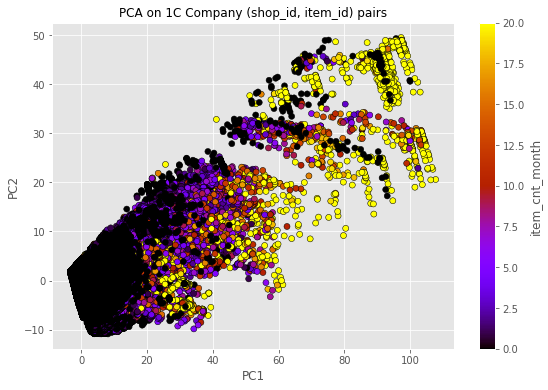

In [45]:
plt.figure(figsize=(9,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df1.item_cnt_month.values[:],
            marker='o', edgecolor='black', cmap='gnuplot')
cbar = plt.colorbar()
cbar.set_label('item_cnt_month')
plt.title('PCA on 1C Company (shop_id, item_id) pairs', fontsize=12)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

While we can't provide an exact confirmation that there exists a linear hidden structure within our training data, this plot thus show some promise as there is a decent separation between `shop-item` pairings that sold well (from January 2013 to October 2015) and those that performed poorly.

Now for **t-distributed stochastic neighbor embedding** (https://distill.pub/2016/misread-tsne/):

NOTE: sklearn's tSNE implementation is computationally expensive, requiring many hours to implement. Thus finding the optimal perplexity through grid search is unfeasible (at least with the sklearn implementation). I will only implement tSNE once with `perplexity = 25`.

In [ ]:
#X_reduced = TruncatedSVD(n_components=20, random_state=0).fit_transform(df1.drop('item_cnt_month', axis=1))
X_embedded = TSNE(n_components=2, perplexity=30.0, verbose=2).fit_transform(X_norm)
X_embedded

In [54]:
#tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12, learning_rate=200,
#            n_iter=1000, n_iter_without_progress=30, min_grad_norm=1e-07, metric='euclidean',
#            init='random', verbose=0, random_state=None, method='barnes_hut', angle=0.5,
#            n_jobs=-1, cheat_metric=True)

#X_embedded = tsne.fit_transform(X_norm)
#X_embedded

In [ ]:
plt.figure(figsize=(9,6))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=df1.item_cnt_month.values,
            marker='o', edgecolor='black', cmap='gnuplot')
cbar = plt.colorbar()
cbar.set_label('item_cnt_month')
plt.title('t-SNE on 1C Company (shop_id, item_id) pairs', fontsize=12)
plt.xlabel('Stochastic embedding 1')
plt.ylabel('Stochastic embedding 2')
plt.show()

# Part 5/6: Model training


## 5.1. Validation scheme

In [53]:
all_data = copy.copy(df1)

X_train = all_data[all_data['date_block_num']<33].drop(['item_cnt_month'], axis=1)
Y_train = all_data[all_data['date_block_num']<33]['item_cnt_month']

X_valid = all_data[all_data['date_block_num']==33].drop(['item_cnt_month'], axis=1)
Y_valid = all_data[all_data['date_block_num']==33]['item_cnt_month']

X_test =  all_data[all_data['date_block_num']==34].drop(['item_cnt_month'], axis=1)

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)

(6186922, 28)
(6186922,)
(238172, 28)
(238172,)
(214200, 28)


## 5.2. Light GBM

In [ ]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_valid, Y_valid)

params = {
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric': 'l2_root',  # RMSE
    'verbose': 1,
    'seed': 0
    'max_depth': 4,
    'eta': 0.01,
}

model_lgbm = lgb.train(params, lgb_train, num_boost_round=1000,
                       valid_sets=lgb_valid, early_stopping_rounds=200,
                       categorical_feature=cat_features, verbose_eval=50)

Y_pred = model_lgbm.predict(X_valid, num_iteration=model_lgbm.best_iteration).clip(0, 20)
Y_test = model_lgbm.predict(X_test,  num_iteration=model_lgbm.best_iteration).clip(0, 20)

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(Y_valid, Y_pred))

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(model_lgbm)

In [ ]:
shap.summary_plot(explainer.shap_values(X_valid), X_valid)

## 5.3. XGBoost

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(max_depth=8, n_estimators=1000, min_child_weight=300,
                         colsample_bytree=0.8, subsample=0.8, eta=0.3, seed=42)

model_xgb.fit(X_train, Y_train, eval_metric='rmse', eval_set=[(X_valid, Y_valid)],
              verbose=True, early_stopping_rounds=100)

Y_pred_xgb = model_xgb.predict(X_valid).clip(0, 20)
Y_test_xgb = model_xgb.predict(X_test).clip(0, 20)

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(model_xgb)
shap.summary_plot(explainer.shap_values(X_valid), X_valid)

## 5.4. CatBoost

## 5.5. LSTM

In [95]:
model_lars = Lars()
model_lars.fit(X_train, Y_train)

# Part 6/6: Ensembling and test predictions

## 6.1. Hyperparameter optimization

In [ ]:
xgb_bayesopt = BayesianOptimization(model_xgb, {'max_depth': (2, 12),
                                                'gamma': (0.001, 10.0),
                                                'min_child_weight': (0, 300),
                                                'max_delta_step': (0, 10), 'subsample': (0.4, 1.0),
                                                'colsample_bytree' :(0.4, 1.0)
                                               })

xgb_bayesopt.explore({
    'max_depth':            [3, 8, 3, 8, 8, 3, 8, 3],
    'gamma':                [0.5, 8, 0.2, 9, 0.5, 8, 0.2, 9],
    'min_child_weight':     [0.5, 5, 15, 30, 50, 100, 200, 300],
    'max_delta_step':       [1, 2, 2, 1, 2, 1, 1, 2],
    'subsample':            [0.6, 0.8, 0.6, 0.8, 0.6, 0.8, 0.6, 0.8],
    'colsample_bytree':     [0.6, 0.8, 0.6, 0.8, 0.6, 0.8, 0.6, 0.8],
})

## 6.2. Ensembling

In [ ]:
X_test_level2 = np.c_[Y_pred, Y_pred1]
print(X_test_level2.shape)
X_test_level2[:10]

In [ ]:
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])
dates = train['date_block_num'].unique()

# Now fill `X_train_level2` with metafeatures
for cur_block_num in dates:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train`;
        2. Fit linear regression ; 
        3. Fit LightGBM and put predictions;          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`; 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`.
    '''      
    
    # 1. Split `X_train` into parts
    X = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1).values
    Y = all_data.loc[dates < cur_block_num, 'target'].values
    X_test = all_data.loc[dates ==  cur_block_num].drop(to_drop_cols, axis=1)
    
    # 2. Fit linear regression
    lr.fit(X, Y)
    lr_pred = lr.predict(X_test)
    
    # 3. Fit LightGBM and put predictions
    lgbm = lgb.train(lgb_params, lgb.Dataset(X, Y), num_boost_round=100)
    lgbm_pred = lgbm.predict(X_test)
    
    # 4. Store predictions from 2. and 3. in the right place of `X_train_level2`
    X_train_level2[dates_train_level2 == cur_block_num] = np.c_[lr_pred, lgbm_pred]

In [ ]:
plt.scatter(X_train_level2[:,0], X_train_level2[:,1], marker='o', edgecolor='black')
plt.show()

## 6.3. Leaderboard test predictions

In [ ]:
sub = pd.DataFrame({'ID': test.index, 'item_cnt_month': Y_test_xgb})
sub.to_csv('submission.csv', index=False)

In [ ]:
plt.hist(Y_test_xgb, bins=50)
plt.show()